Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for ./notMNIST_large. This may take a while. Please wait.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
Extracting data for ./notMNIST_small. This may take a while. Please wait.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [17]:
some_data=["./notMNIST_small/A/QXZhbG9uLm90Zg==.png", 
           "./notMNIST_small/A/QXRsYW50aXggU1NpIFNlbWkgQm9sZCBJdGFsaWMudHRm.png",
           "./notMNIST_small/B/SVRDIEF2YW50IEdhcmRlIEdvdGhpYyBFeHRyYSBMaWdodCBPYmxpcXVlLnBmYg==.png"
          ]
for letter in some_data:
    print(letter)
    display(Image(filename=str(letter)))

./notMNIST_small/A/QXZhbG9uLm90Zg==.png


./notMNIST_small/A/QXRsYW50aXggU1NpIFNlbWkgQm9sZCBJdGFsaWMudHRm.png


./notMNIST_small/B/SVRDIEF2YW50IEdhcmRlIEdvdGhpYyBFeHRyYSBMaWdodCBPYmxpcXVlLnBmYg==.png


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [18]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.44312
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.454491
Pickli

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

['./notMNIST_large/A.pickle', './notMNIST_large/B.pickle', './notMNIST_large/C.pickle', './notMNIST_large/D.pickle', './notMNIST_large/E.pickle', './notMNIST_large/F.pickle', './notMNIST_large/G.pickle', './notMNIST_large/H.pickle', './notMNIST_large/I.pickle', './notMNIST_large/J.pickle']


(<matplotlib.figure.Figure at 0x7f922c9b7890>,
 <matplotlib.image.AxesImage at 0x7f922c88a490>)

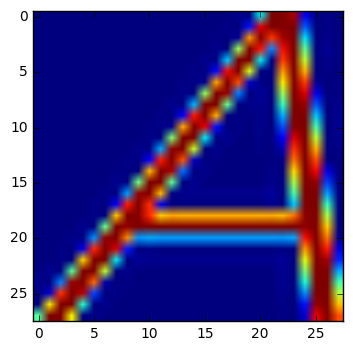

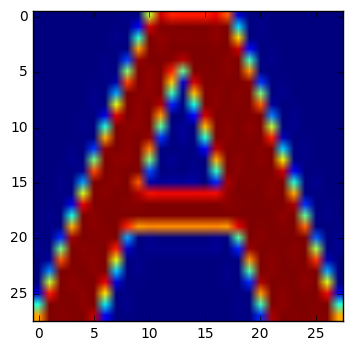

In [28]:
print(train_datasets)
a_dataset=pickle.loads(open('./notMNIST_large/A.pickle').read())
plt.figure(), plt.imshow(a_dataset[0,:,:])
plt.figure(), plt.imshow(a_dataset[1000,:,:])

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [42]:
def is_data_balanced(counts_per_class, stddev_th = 0.4):
    m = np.mean(counts_per_class)
    d = np.std(counts_per_class)
    print("Mean   = {}".format(m))
    print("StdDev = {}".format(d))
    # If Std Dev is lesser than a certain percentage of the mean, we can conclude that data may be unbalanced
    if (d > m*stddev_th):
        print("Data may not be well balanced!")
        return False    
    
    print("Data seems to be well balanced")
    return True
    
# Do all the classes have a similar number of examples?
shapes_tr=np.empty((0,3))
for train_dataset in train_datasets:
    tr_dset=pickle.loads(open(train_dataset).read())
    shapes_tr = np.vstack((shapes_tr, np.asarray(tr_dset.shape)))
    #print("{}: {}".format(train_dataset, tr_dset.shape))
print("Balance of training data...")
is_data_balanced(shapes_tr[:,0])
    
shapes_ts=np.empty((0,3))
for test_dataset in test_datasets:
    ts_dset=pickle.loads(open(test_dataset).read())
    shapes_ts = np.vstack((shapes_ts, np.asarray(ts_dset.shape)))
    #print("{}: {}".format(test_dataset, ts_dset.shape))
print("\nBalance of testing data...")
is_data_balanced(shapes_ts[:,0])

Balance of training data...
Mean   = 52911.4
StdDev = 0.916515138991
Data seems to be well balanced

Balance of testing data...
Mean   = 1872.4
StdDev = 0.489897948557
Data seems to be well balanced


True

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [43]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        # Valid is none when we want to merge the test datasets
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [44]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Mean   = 20000.0
StdDev = 0.0
Data seems to be well balanced


True

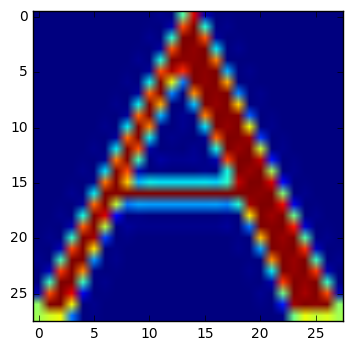

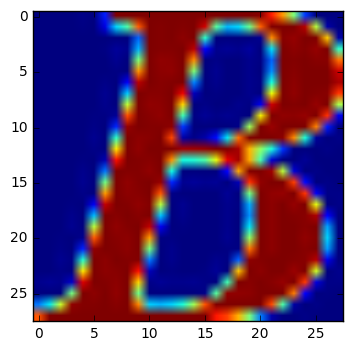

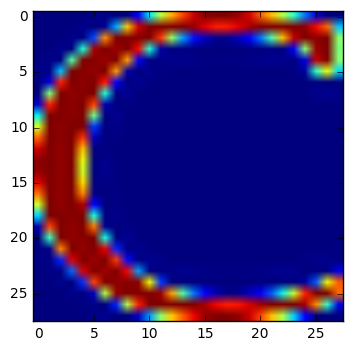

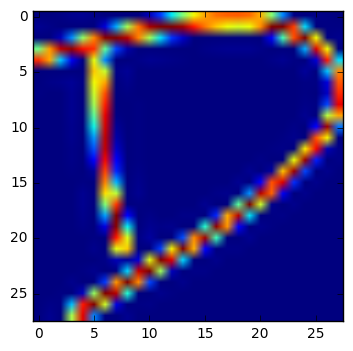

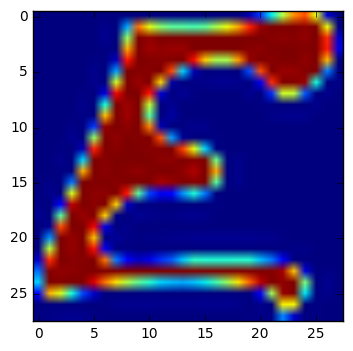

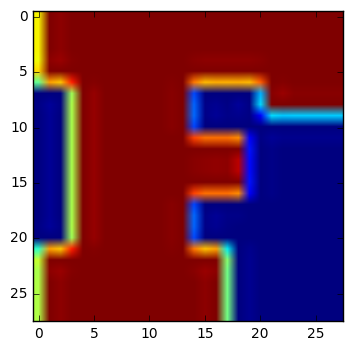

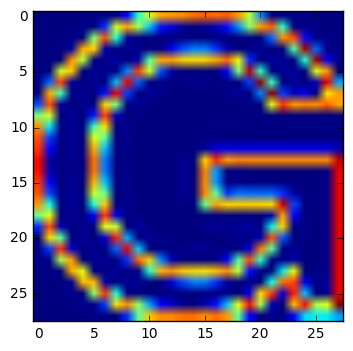

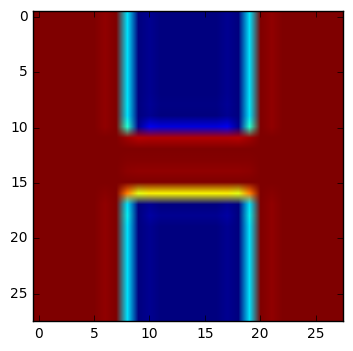

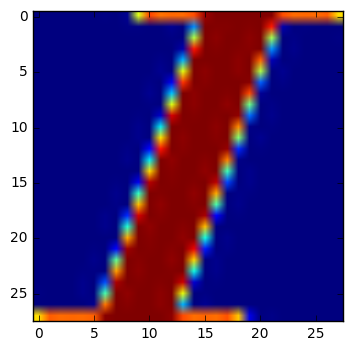

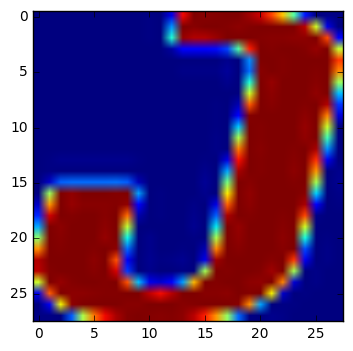

In [48]:
def check_balance_of_shuffled_data(labels, dataset):
    #Count number of samples per category label
    uniq_labels = np.unique(labels)
    counts = []
    for ulabel in uniq_labels:
        categ_idxs = np.where(labels==ulabel)[0]
        counts += [len(categ_idxs)]
        plt.figure(), plt.imshow(dataset[categ_idxs[0],:,:])
    return is_data_balanced(np.asarray(counts))

check_balance_of_shuffled_data(train_labels, train_dataset)
    

Mean   = 1000.0
StdDev = 0.0
Data seems to be well balanced


True

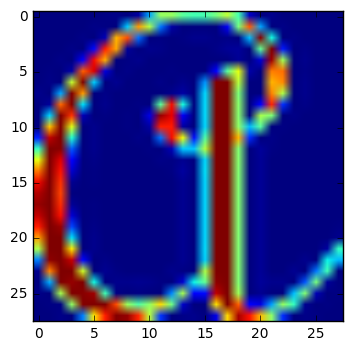

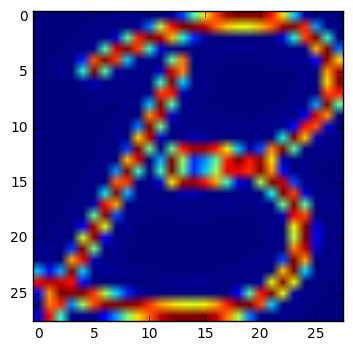

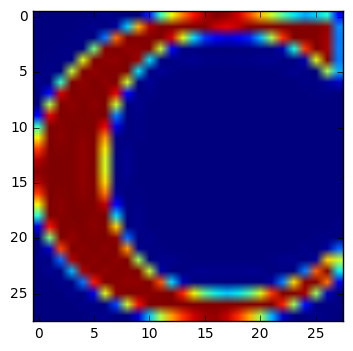

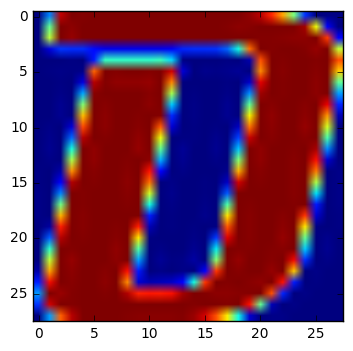

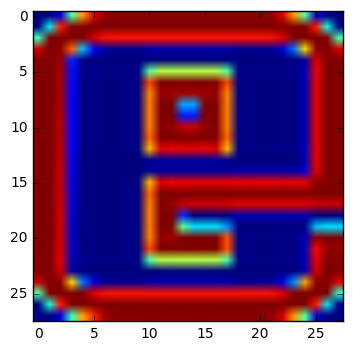

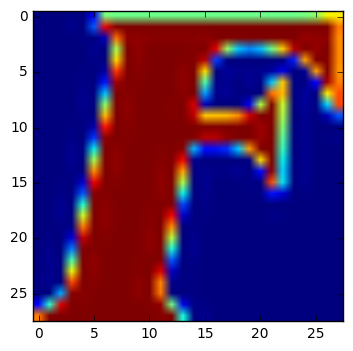

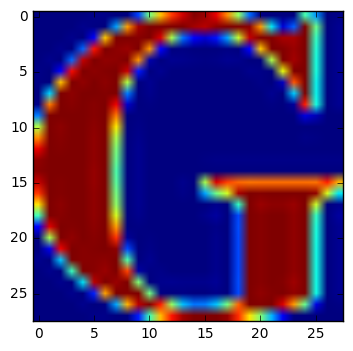

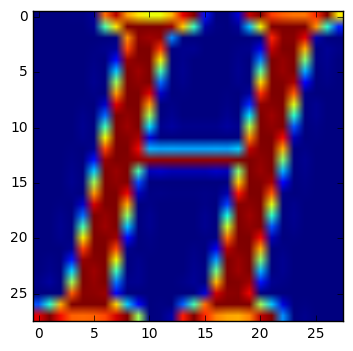

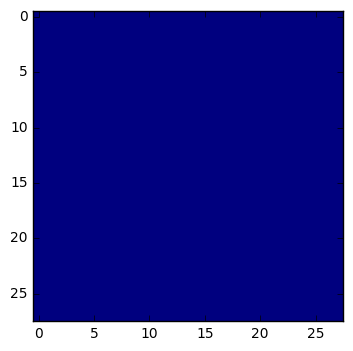

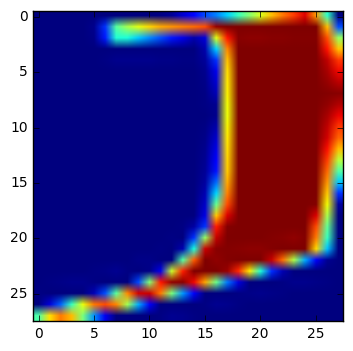

In [49]:
check_balance_of_shuffled_data(valid_labels, valid_dataset)

Mean   = 1000.0
StdDev = 0.0
Data seems to be well balanced


True

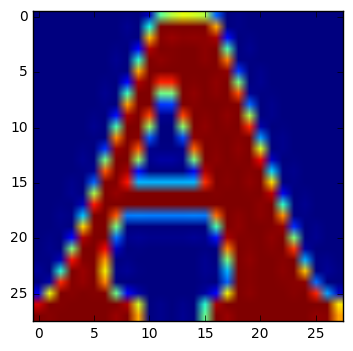

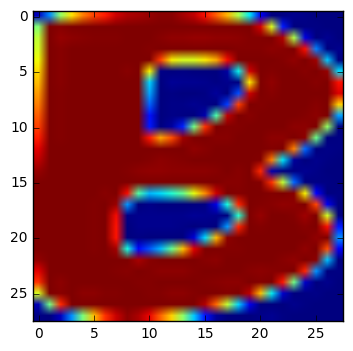

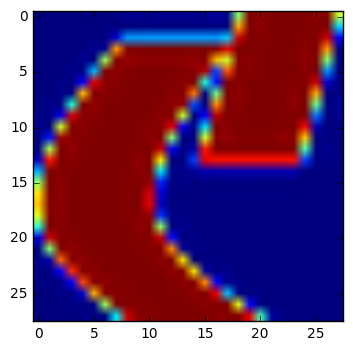

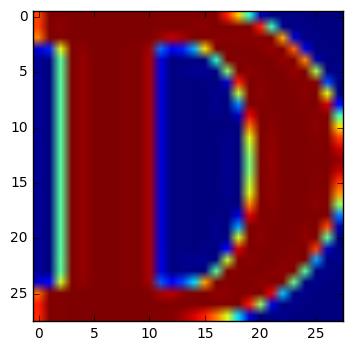

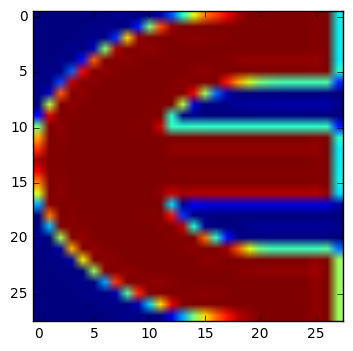

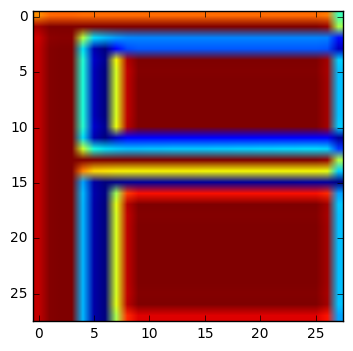

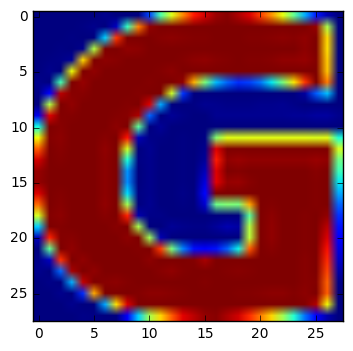

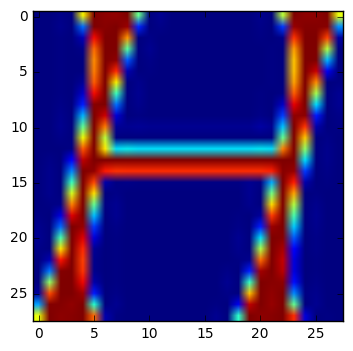

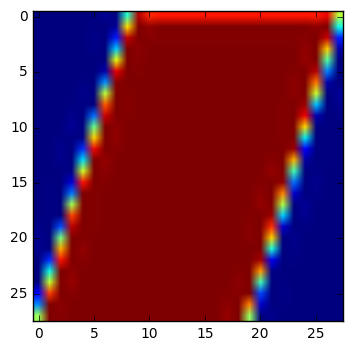

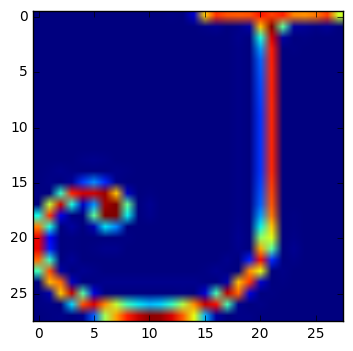

In [50]:
check_balance_of_shuffled_data(test_labels, test_dataset)

Finally, let's save the data for later reuse:

In [51]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [52]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [71]:
from time import time
def check_overlap(dataset1, dataset2):
    # ===================================================
    #                                     FIND DUPLICATES
    # ===================================================
    # Inspired by eythian's and ronrest method for duplicates
    # https://discussions.udacity.com/t/assignment-1-problem-5/45657/10
    t0 = time()
    # Set data to read only so we can create hashes
    dataset1.flags.writeable=False
    dataset2.flags.writeable=False

    # Get hashes for all images as a list (to preserve indices)
    dataset1_hashes = [hash(image.data) for image in dataset1]
    dataset2_hashes = [hash(image.data) for image in dataset2]

    # Unique set of hashes found in dataset1. And the set of hashes in dataset2
    # that overlap with the hashes the dataset1
    unique_dataset1_hashes = set(dataset1_hashes)
    dataset2_overlap_hashes = unique_dataset1_hashes.intersection(set(dataset2_hashes))
    unique_dataset2_hashes = set(dataset2_hashes).difference(dataset2_overlap_hashes)

    # ----------------------------------------------------
    #                                 Create Dictionaries
    # ----------------------------------------------------
    # Dictionary Keys represent every unique hash from the training data.
    # Dictionary Values are lists of indices in the corresponding dataset have that 
    # hash.

    # Initialise the dictionaries with empty lists
    dataset1_hash_dict = {val: [] for val in unique_dataset1_hashes}
    dataset2_hash_dict = {val: [] for val in unique_dataset2_hashes}

    # For the dataset1 set, append the indices to the corresponding hash
    filter(lambda (i,val): dataset1_hash_dict[val].append(i), enumerate(dataset1_hashes))
    
    # For dataset2 set, append indices only if the hash doesn't overlap with dataset1 set
    for i, image_hash in enumerate(dataset2_hashes):
        if image_hash in unique_dataset2_hashes:
            dataset2_hash_dict[image_hash].append(i)
            
    print("Found ", len(dataset1_hashes)-len(dataset1_hash_dict) ," duplicated dataset1 indices in ", time() - t0, " seconds")
    print("Found ", len(dataset2_hashes)-len(dataset2_hash_dict) ," duplicated dataset2 indices in ", time() - t0, " seconds")
    print("Found ", len(dataset2_overlap_hashes) ," duplicated between datasets")    
    
    # Output a single image index for each unique hash in dataset in order to further create sanitized datasets
    dataset1_indices_list = []
    for val in dataset1_hash_dict.keys():        
        current_idxs = dataset1_hash_dict[val]
        dataset1_indices_list += [current_idxs[0]]
    
    dataset2_indices_list = []
    for val in dataset2_hash_dict.keys():
        current_idxs = dataset2_hash_dict[val]        
        dataset2_indices_list += [current_idxs[0]]
    
    return dataset1_indices_list, dataset2_indices_list

# check overlaps and creates sanitized datasets
print(" Check overlaps and sanitize datasets")
train_idxs, valid_idxs = check_overlap(train_dataset, valid_dataset)
train_idxs, test_idxs = check_overlap(train_dataset, test_dataset)
valid_idxs, test_idxs = check_overlap(valid_dataset, test_dataset)

print("train_idxs: {}".format(len(train_idxs)))
print("valid_idxs: {}".format(len(valid_idxs)))
print("test_idxs: {}".format(len(test_idxs)))

sanitized_train_dataset = [train_dataset[x] for x in train_idxs]
sanitized_valid_dataset = [valid_dataset[x] for x in valid_idxs]
sanitized_test_dataset = [test_dataset[x] for x in test_idxs]

 Check overlaps and sanitize datasets
Found  12866  duplicated dataset1 indices in  2.07418489456  seconds
Found  1066  duplicated dataset2 indices in  2.07510185242  seconds
Found  924  duplicated between datasets
Found  12866  duplicated dataset1 indices in  1.92452597618  seconds
Found  1338  duplicated dataset2 indices in  1.9252820015  seconds
Found  1127  duplicated between datasets
Found  142  duplicated dataset1 indices in  0.133634805679  seconds
Found  277  duplicated dataset2 indices in  0.135426998138  seconds
Found  66  duplicated between datasets
train_idxs: 187134
valid_idxs: 9858
test_idxs: 9723


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---